In [20]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import*
import os


bolc_const = 1000.0
max_const = 5226.385906601731
K2 = 0.09566840431136607

#Zr = 5.322227554316827 (длина волны 850, ширина 1.2 мкм)
Zr = 3.717861128508631 #(длина волны 845, ширина 1 мкм)
#maxvell_c = 0.009781022661836853
ω0 = 1.0

In [21]:
def ω(z):
    return ω0*sqrt(1+(z/Zr)**2)

def exp_func(x,y,z):
    return exp(-2*(x**2+y**2)/(ω(z))**2)

def U_coord(U0,x,y,z):
    return -U0*((ω0/ω(z))**2)*exp_func(x,y,z)

In [22]:
def likelihood(arg, U0, T):
    # Standard Normal Distribution
    # An underlying assumption of linear regression is that the residuals
    # are Gaussian Normal Distributed; often, Standard Normal distributed
    #return np.exp(-2*x**2 / 2) / np.sqrt(2 * np.pi)
    return exp(-U_coord(U0,arg[0],arg[2],arg[4])*bolc_const/T)*exp(-(arg[1]**2+arg[3]**2+arg[5]**2)*max_const/T)

In [23]:
def proposal_distribution(x, stepsize=[ω0,0.3,ω0,0.3,Zr,0.3]):
    # Select the proposed state (new guess) from a Gaussian distribution
    #  centered at the current state, within a Guassian of width `stepsize`
    return np.random.normal(x, stepsize)

In [24]:
def mcmc_updater(U0,T,curr_state, curr_likeli, likelihood, proposal_distribution,stepsize):
    # Generate a proposal state using the proposal distribution
    # Proposal state == new guess state to be compared to current
    proposal_state = proposal_distribution(curr_state,stepsize)

    # Calculate the acceptance criterion
    prop_likeli = likelihood(proposal_state,U0,T)
    accept_crit = prop_likeli / curr_likeli

    # Generate a random number between 0 and 1
    accept_threshold = np.random.uniform(0, 1)

    # If the acceptance criterion is greater than the random number,
    # accept the proposal state as the current state
    if accept_crit > accept_threshold:
        return proposal_state, prop_likeli

    # Else
    return curr_state, curr_likeli

In [25]:
def comparation(new_state,curr_state):
    for i in range(len(new_state)):
        if new_state[i]!=curr_state[i]:
            return False
    return True

In [26]:
def high_energy(y,U0):  #вычисление энергии атома в пинце в момент остановки
    if (y[1]**2+y[3]**2+y[5]**2)+2*K2*U_coord(U0,y[0],y[2],y[4]) < 0:
        return False
    return True

In [27]:
def metropolis_hastings(
         U0, T, likelihood, proposal_distribution, initial_state, 
        num_samples, stepsize):
    #preparated_samples = []
    samples = []

    # The number of samples in the burn in phase
    #idx_burnin = int((1 -burnin) * num_samples)

    # Set the current state to the initial state
    curr_state = initial_state
    curr_likeli = likelihood(curr_state,U0,T)
    
    #New state for cycle
    new_state = curr_state
    
    for i in range(num_samples):
        # The proposal distribution sampling and comparison
        #   occur within the mcmc_updater routine
        if i%1000==0: print(i)
        while(comparation(new_state,curr_state) or high_energy(new_state,U0)):
            new_state, new_likeli = mcmc_updater(
                U0,T,
                curr_state=curr_state,
                curr_likeli=curr_likeli,
                likelihood=likelihood,
                proposal_distribution=proposal_distribution,
                stepsize=stepsize
            )
        curr_state = new_state
        curr_likeli = new_likeli 
        #curr_state, curr_likeli = mcmc_updater(
        #    curr_state=curr_state,
        #    curr_likeli=curr_likeli,
        #    likelihood=likelihood,
        #    proposal_distribution=proposal_distribution
        #)

        # Append the current state to the list of samples
        #if i >= idx_burnin:
            # Only append after the burnin to avoid including
            #   parts of the chain that are prior-dominated
        #    samples.append(curr_state)
        #preparated_samples.append(curr_state)
        samples.append(curr_state)
    
    #for i in range(idx_burnin):
    #    index = int(np.random.uniform(num_samples-1))
    #    samples.append(preparated_samples[index])

    return samples

In [28]:
def cut_sample(request,samples):
    res = []
    for i in range(request):
        index = int(np.random.uniform(num_samples-1))
        res.append(samples[index])
    return res

In [32]:
np.random.seed(43)

initial_state = [0.0,0.0,0.0,0.0,0.0,0.0]  # Trivial case, starting at the mode of the likelihood
num_samples = int(1e3)

U0 = 1.2
T = 35

stepsize=np.array([ω0,0.3,ω0,0.3,Zr,0.3])*0.2

samples = metropolis_hastings(
    U0,
    T,
    likelihood,
    proposal_distribution,
    initial_state,
    num_samples,
    stepsize
)

0


In [41]:
file = open("conditions.txt", "w")
file.write(str(len(samples)) + '\n')
for sample in samples:
    for number in sample:
        file.write(str(number) + ' ')
file.close()

In [33]:
x = [e[0] for e in samples]
y = [e[2] for e in samples]
z = [e[4] for e in samples]
Vx = [e[1] for e in samples]
Vy = [e[3] for e in samples]
Vz = [e[5] for e in samples]

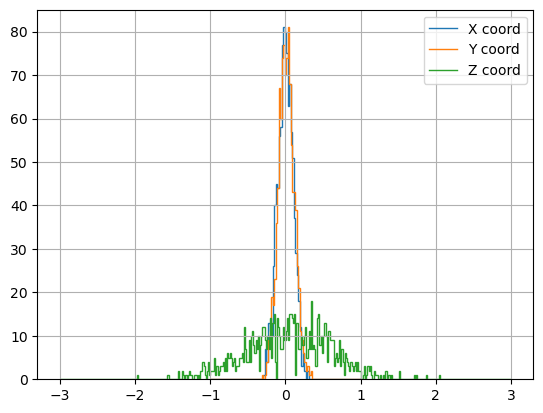

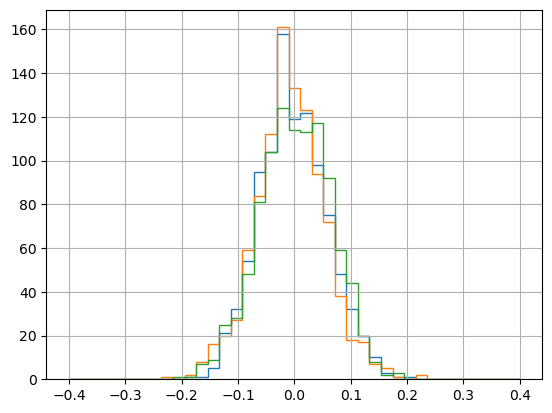

In [34]:
#T = 50
counts1, bins1 = np.histogram(x,bins=np.linspace(-1, 1, 100))
plt.stairs(counts1, bins1, label = 'X coord')

counts2, bins2 = np.histogram(y,bins=np.linspace(-1, 1, 100))
plt.stairs(counts2, bins2, label = 'Y coord')

counts3, bins3 = np.histogram(z,bins=np.linspace(-3,3, 400))
plt.stairs(counts3, bins3, label = 'Z coord')

plt.legend()
plt.grid()
plt.show()

counts4, bins4 = np.histogram(Vx,bins=np.linspace(-0.4, 0.4, 40))
plt.stairs(counts4, bins4)

counts5, bins5 = np.histogram(Vy,bins=np.linspace(-0.4, 0.4, 40))
plt.stairs(counts5, bins5)

counts6, bins6 = np.histogram(Vz,bins=np.linspace(-0.4, 0.4, 40))
plt.stairs(counts6, bins6)

plt.grid()
plt.show()

In [238]:
bins2

array([-24.15121073, -20.18191419, -16.21261765, -12.2433211 ,
        -8.27402456,  -4.30472802,  -0.33543148,   3.63386507,
         7.60316161,  11.57245815,  15.54175469])

In [13]:
#T = 100
x = [e[0] for e in samples]
z = [e[2] for e in samples]
Vx = [e[1] for e in samples]
Vz = [e[3] for e in samples]

In [14]:
len(x)

10000

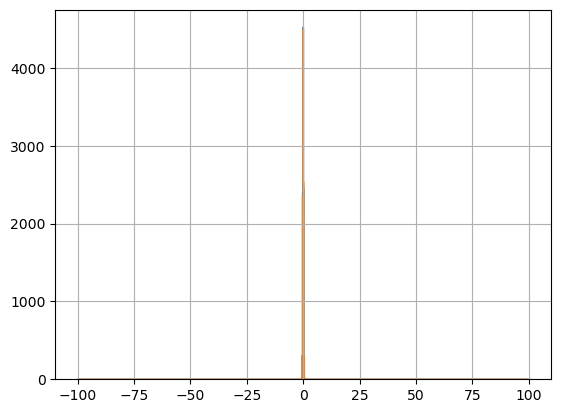

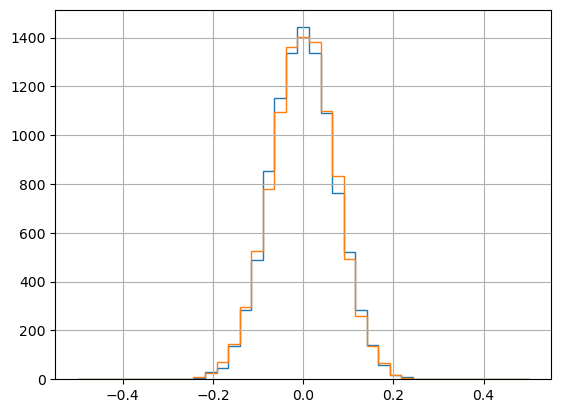

In [15]:
counts1, bins1 = np.histogram(x,bins=np.linspace(-100, 100, 1000))
plt.stairs(counts1, bins1)

counts2, bins2 = np.histogram(z,bins=np.linspace(-100, 100, 1000))
plt.stairs(counts2, bins2)

plt.grid()
plt.show()

counts3, bins3 = np.histogram(Vx,bins=np.linspace(-0.5, 0.5, 40))
plt.stairs(counts3, bins3)

counts4, bins4 = np.histogram(Vz,bins=np.linspace(-0.5, 0.5, 40))
plt.stairs(counts4, bins4)

plt.grid()
plt.show()

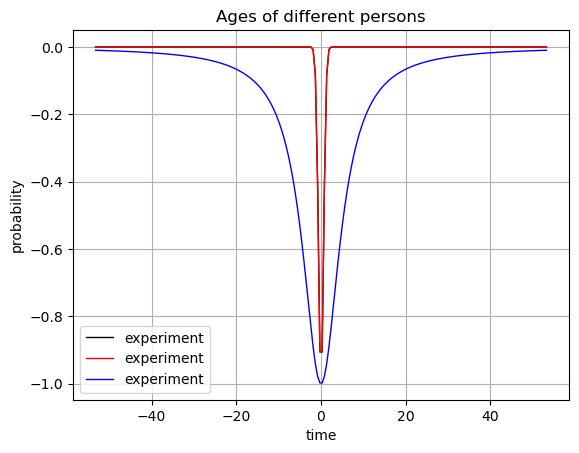

In [195]:
z = linspace(-Zr*10,Zr*10,200)
y1 = U_coord(1,z,0,0)
y2 = U_coord(1,0,z,0)
y3 = U_coord(1,0,0,z)
plt.plot(z, y1, color = 'black', label = "experiment",linewidth= 1)  
plt.plot(z, y2, color = 'red', label = "experiment",linewidth= 1) 
plt.plot(z, y3, color = 'blue', label = "experiment",linewidth= 1) 
plt.xlabel('time') 
plt.ylabel('probability')
plt.title('Ages of different persons') 
plt.legend() 
plt.grid()
plt.show() 